<h1 style="text-align: center">Yelp Rating Prediction</h1>
<hr style="border-top: 1px solid #444">

## Development Environment

In [1]:
from typing import TypedDict, Dict, List
from statistics import mean, stdev
import sys, os, json, time
import spectra, numpy, pandas, sklearn, tensorflow
import matplotlib.pyplot as pyplot
import matplotlib.ticker as ticker

# store standard out stream
original_stdout = sys.stdout

print(f"Python: {sys.version}")
print(f"Numpy {numpy.__version__}")
print(f"Pandas {pandas.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
print(f"Tensor Flow Version: {tensorflow.__version__} (Keras Version: {tensorflow.keras.__version__})")

Python: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.1.2
Scikit-Learn 0.23.2
Tensor Flow Version: 2.3.0 (Keras Version: 2.4.0)


<hr style="border-top: 1px solid #444">

# I. Data Importation

## Dataset Location

In [2]:
file_businesses = r"data/yelp_academic_dataset_business.json"
file_user_reviews = r"data/yelp_academic_dataset_review.json"

## Import Yelp Businesses

In [3]:
start_time = time.time()

# business structure
class Business(TypedDict):
    business_id: str
    name: str
    address: str
    city: str
    state: str
    postal_code: str
    latitude: float
    longitude: float
    stars: float
    review_count: int
    is_open: int
    attributes: Dict
    categories: List[str]
    hours: Dict

# businesses indexed by business_id (i.e. {business['business_id']: Business}
businesses_by_id: Dict[str, Business] = {}

# parse all businesses
with open(file_businesses, 'r', encoding='utf-8') as file:
    # iterate over newline-deliminted JSON records
    record: str
    for record in file:
        # parse JSON record
        business: Business = json.loads(record)
        # map Business by business_id
        businesses_by_id[business['business_id']] = business

print(f"Imported {len(businesses_by_id):,} distinct businesses in {time.time() - start_time:.6f} seconds")

Imported 209,393 distinct businesses in 4.491913 seconds


## Import User Review Texts

In [4]:
start_time = time.time()

# user review structure
class UserReview(TypedDict):
    review_id: str
    user_id: str
    business_id: str
    date: str
    stars: int # [0, 1, 2, 3, 4, 5]
    text: str
    # review ratings
    useful: int
    funny: int
    cool: int

# user reviews indexed by business_id (i.e. {business_id: UserReview[]})
business_review_texts: Dict[str, List[str]] = {
    business_id: [] for business_id in businesses_by_id.keys()
}

# parse user reviews
with open(file_user_reviews, 'r', encoding='utf-8') as file:
    # iterate over newline-deliminted JSON records
    record: str
    for record in file:
        # parse JSON record
        review: UserReview = json.loads(record)
        # map user review by business_id
        business_review_texts[review['business_id']].append(review["text"])

print(f"Imported {sum([len(reviews) for reviews in business_review_texts.values()]):,} user reviews in {time.time() - start_time:.6f} seconds")

Imported 8,021,122 user reviews in 89.430788 seconds


<hr style="border-top: 1px solid #444">

## II. Dataset Visualizations

### Star Rating Distribution

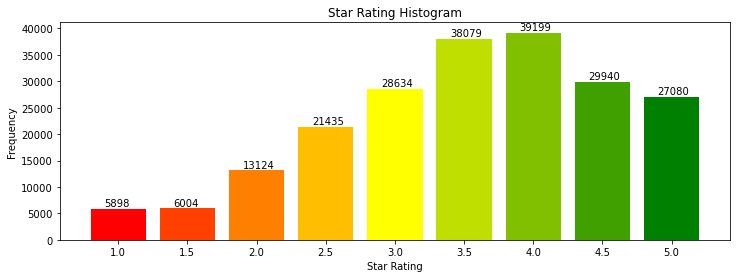

Rendered graphic in 0.532063 seconds


In [5]:
start_time = time.time()

pyplot.figure(figsize=(12, 4))
pyplot.title("Star Rating Histogram")
pyplot.xlabel("Star Rating")
pyplot.ylabel("Frequency")

star_color = spectra.scale(['red', 'yellow', 'green'])
for star_rating, frequency in pandas.DataFrame(businesses_by_id.values(), columns=['stars'])['stars'].value_counts().sort_index().items():
    pyplot.bar(str(star_rating), frequency, color = star_color((star_rating - 1)/ 4).hexcode)
    pyplot.text((star_rating-1) * 2-.2, frequency + 400, frequency)

pyplot.show()

print(f"Rendered graphic in {time.time() - start_time:.6f} seconds")

### Review Count Distribution

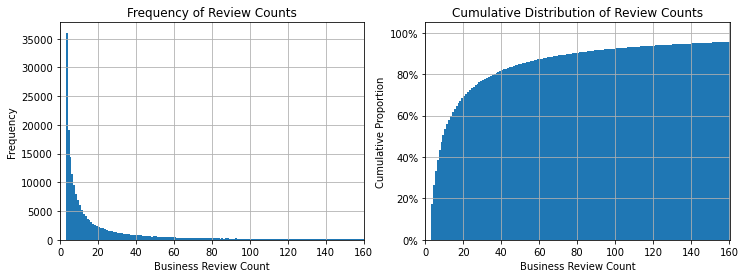

Rendered graphic in 37.895838 seconds


In [6]:
start_time = time.time()

stars = [business['review_count'] for business in businesses_by_id.values()]

figure = pyplot.figure(figsize=(12, 4))
axes = figure.add_subplot(1, 2, 1)
axes.set_title("Frequency of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(stars) + stdev(stars))
axes.set_ylabel("Frequency")
axes.grid(True)
axes.hist(stars, bins = list(range(0, max(stars))))

## Cumulative
axes = figure.add_subplot(1, 2, 2)
axes.set_title("Cumulative Distribution of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(stars) + stdev(stars))
axes.set_ylabel("Cumulative Proportion")
axes.yaxis.set_major_formatter(ticker.FuncFormatter('{0:.0%}'.format))
axes.grid(True)
pyplot.hist(stars, bins=list(range(0, max(stars))), cumulative=True,  density=True)

pyplot.show()

print(f"Rendered graphic in {time.time() - start_time:.6f} seconds")

<hr style="border-top: 1px solid #444">

## III. Training Data Selection

## Select businesses with more than X reviews

In [7]:
# minimum business["review_count"] required for a business to not be filtered
MINIMUM_REVIEW_COUNT = 10

start_time = time.time()

# filter out businesses with less than MINIMUM_REVIEW_COUNT reviews
filtered_businesses = [business for business in businesses_by_id.values() if MINIMUM_REVIEW_COUNT <= business["review_count"]]

print(f"{len(filtered_businesses):,} selected businesses (filtered {len(businesses_by_id) - len(filtered_businesses)}) in {time.time() - start_time:.6f} seconds")

103,803 selected businesses (filtered 105590) in 0.084072 seconds


## Partition businesses for model training and testing

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# "represents the absolute number of test samples"
TRAINING_SIZE = 10_000
# "represents the absolute number of train samples"
TESTING_SIZE = 10_000

start_time = time.time()

# split businesses into two disjoint subsets: training and testing
from sklearn.model_selection import train_test_split
train_businesses: List[Business]
test_businesses: List[Business]
train_businesses, test_businesses = train_test_split(
    # set to partition
    filtered_businesses,
    # partition proportions
    train_size = TRAINING_SIZE,
    test_size = TESTING_SIZE,
    # shuffle the data
    shuffle = True,
    # PRNG seed for deterministic behaviour
    random_state = 42
)

print(f"Partitioned {len(train_businesses) + len(test_businesses):,} businesses into {{training: {len(train_businesses)}, testing: {len(test_businesses)}}} in {time.time() - start_time:.6f} seconds")

Partitioned 20,000 businesses into {training: 10000, testing: 10000} in 1.546942 seconds


<hr style="border-top: 1px solid #444">

# IV. Model Training

## Data Preprocessing

### Input Features

#### Concatenate User Reviews

In [9]:
start_time = time.time()

# concatenated user review texts indexed by business_id (i.e. {business_id: review_text}})
business_concatenated_reviews: Dict[str, str] = {}

# process each business in the training and testing datasets
business: Business
for business in train_businesses + test_businesses:
    business_id: str = business['business_id']
    business_concatenated_reviews[business_id] = "\n".join(business_review_texts[business_id])

# metrics
print(f"Processed {len(train_businesses) + len(test_businesses):,} businesses in {time.time() - start_time:.6f} seconds")

Processed 20,000 businesses in 1.181998 seconds


#### Vectorize review texts using TFIDF vectorization NLP

In [10]:
start_time = time.time()

from sklearn.feature_extraction.text import TfidfVectorizer
# construct vectorizer
vectorizer: TfidfVectorizer = TfidfVectorizer(
    # maximum word features
    max_features = 500,
    # prune english stop words
    stop_words = 'english',
    # min_df: ignore terms that have a document frequency < min_df.
    # min_df = 10, (redundant for large data sets)
)

# construct corpus from training data
train_reviews_tfidf = vectorizer.fit_transform(
    [business_concatenated_reviews[business['business_id']] for business in train_businesses]
).toarray()

# transform corpus of testing data
test_reviews_tfidf = vectorizer.transform(
    [business_concatenated_reviews[business['business_id']] for business in test_businesses]
).toarray()

# metrics
print(f"Training matrix shape: {train_reviews_tfidf.shape}")
print(f"Word features cardinality: {len(vectorizer.get_feature_names()):,}")
print(f"Word features: {vectorizer.get_feature_names()}")
print(f"IDF Vectorized {len(train_businesses) + len(test_businesses):,} businesses review texts in {time.time() - start_time:.6f} seconds")

Training matrix shape: (10000, 500)
Word features cardinality: 500
Word features: ['00', '10', '12', '15', '20', '30', '50', 'able', 'absolutely', 'actually', 'add', 'ago', 'amazing', 'appetizer', 'appointment', 'area', 'arrived', 'ask', 'asked', 'ate', 'atmosphere', 'attentive', 'authentic', 'available', 'average', 'away', 'awesome', 'bacon', 'bad', 'bar', 'bbq', 'beautiful', 'beef', 'beer', 'believe', 'best', 'better', 'big', 'birthday', 'bit', 'bite', 'bowl', 'bread', 'breakfast', 'bring', 'brought', 'brunch', 'buffet', 'burger', 'burgers', 'business', 'busy', 'buy', 'cake', 'called', 'came', 'car', 'card', 'care', 'change', 'charge', 'cheap', 'check', 'cheese', 'chef', 'chicken', 'chips', 'chocolate', 'choice', 'choose', 'clean', 'close', 'coffee', 'cold', 'come', 'comes', 'comfortable', 'coming', 'company', 'completely', 'cooked', 'cool', 'cost', 'couldn', 'counter', 'couple', 'course', 'crab', 'cream', 'crispy', 'curry', 'customer', 'customers', 'cut', 'day', 'days', 'deal', 'dec

#### Input Matrix

In [11]:
# training
train_tf_input = train_reviews_tfidf
print("Training:")
print(f"\tFeatures shape: {train_tf_input.shape}")

# testing
test_tf_input = test_reviews_tfidf
print("Testing:")
print(f"\tFeatures shape: {test_tf_input.shape}")

Training:
	Features shape: (10000, 500)
Testing:
	Features shape: (10000, 500)


### Output Features

#### Star Rating

In [12]:
train_stars = numpy.array([[business['stars']] for business in train_businesses])
test_stars = numpy.array([[business["stars"]] for business in test_businesses])

#### Output Matrix

In [13]:
# training
train_tf_output = train_stars
print("Training:")
print(f"\tFeatures shape: {train_tf_output.shape}")

# testing
test_tf_output = test_stars
print("Testing:")
print(f"\tFeatures shape: {test_tf_output.shape}")

Training:
	Features shape: (10000, 1)
Testing:
	Features shape: (10000, 1)


## Neural Network Training

## Training

In [14]:
start_time = time.time()

# imports
from io import StringIO
from IPython.core.display import display, HTML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Capture standard output
# replace standard out for intercepting logging
sys.stdout = captured_stdout = StringIO()

## Train Model
# build model
model = Sequential()
# add new neurons
model.add(Dense(50, input_dim = train_tf_input.shape[1]))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1))
# set optimizer for gradient descent
model.compile(loss = 'mean_squared_error', optimizer = 'sgd', metrics = ['mse'])

# make temporary directory for saved model
if not os.path.exists("temp"):
    os.mkdir("temp")
# run model training
model.fit(
    # training data
    train_tf_input, train_tf_output,
    # use test data to validate losses, but not for training
    validation_data = (test_tf_input, test_tf_output),
    callbacks = [
        # patience: number of epochs with no improvement after which training will be stopped
        EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 25, mode = 'auto', verbose = 0),
        # save best model from all trials
        ModelCheckpoint(filepath = "temp/model_best_weights.hdf5", save_best_only = True, verbose = 0)
    ],
    verbose = 2,
    epochs = 250
)

## Logging
# restore standard out
sys.stdout = original_stdout

print(f"Model trained in {time.time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>Training Details</b></summary>\
        <sub><sup>\
            {"<br>".join(captured_stdout.getvalue().splitlines())}\
        </sup></sub>\
    </details>\
'))

Model trained in 81.749790 seconds


<hr style="border-top: 1px solid #444">

# V. Testing & Analysis

## Compute Predictions

In [15]:
start_time = time.time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")

# compute predicted ratings for test dataset
predicted = model.predict(test_tf_input)
# map predictions to the nearest half-star
predicted_rounded = numpy.array([min(round(prediction * 2) / 2, 5) for prediction in predicted.flatten()])

print(f"Predicted {len(test_businesses)} business ratings in {time.time() - start_time:.6f} seconds")

Predicted 10000 business ratings in 0.723281 seconds


## Error Scoring (MSE/RSME) & Lift Chart Visualizations

### Continuous Predictions

MSE Score: 0.11744185508564385
RMSE Score: 0.3426979064506287


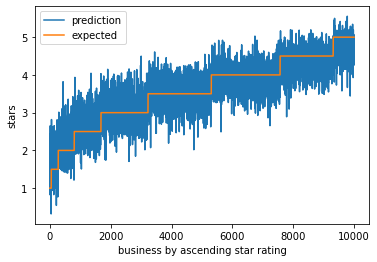

In [16]:
# measure MSE error
mse_score = sklearn.metrics.mean_squared_error(predicted, test_tf_output)

# measure MSE error
print(f"MSE Score: {mse_score}")
# measure RMSE error
print(f"RMSE Score: {numpy.sqrt(mse_score)}")

%matplotlib inline
table = pandas.DataFrame({'predicted' : predicted.flatten(), 'y' : test_tf_output.flatten()})
table.sort_values(by = ['y'], inplace = True)
pyplot.plot(table['predicted'].tolist(), label = "prediction")
pyplot.plot(table['y'].tolist(), label = "expected")
pyplot.xlabel("business by ascending star rating")
pyplot.ylabel("stars")
pyplot.legend()
pyplot.show()

### Discrete Predictions

MSE Score: 0.136375
RMSE Score: 0.3692898590538332


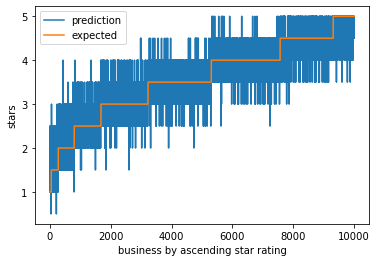

In [17]:
# measure MSE error
mse_score = sklearn.metrics.mean_squared_error(predicted_rounded, test_tf_output)

# measure MSE error
print(f"MSE Score: {mse_score}")
# measure RMSE error
print(f"RMSE Score: {numpy.sqrt(mse_score)}")

%matplotlib inline
table = pandas.DataFrame({'predicted' : predicted_rounded.flatten(), 'y' : test_tf_output.flatten()})
table.sort_values(by = ['y'], inplace = True)
pyplot.plot(table['predicted'].tolist(), label = "prediction")
pyplot.plot(table['y'].tolist(), label = "expected")
pyplot.xlabel("business by ascending star rating")
pyplot.ylabel("stars")
pyplot.legend()
pyplot.show()